In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epam.sequences import translate_sequences

We're going to be interested in the frequency of multinucleotide mutations, which is the number of mutations per codon, even if this isn't a coding sequence.

In [2]:
def count_multi_mutations(indicator_vector):
    "Counts the number of mutations that are in a codon with at least 2 mutations."
    # Trim the vector so its length is a multiple of 3
    n = len(indicator_vector)
    n_codons = n // 3
    trimmed_vector = indicator_vector[:n_codons * 3]
    
    # Reshape the vector into a 2D array where each row represents a codon
    codon_matrix = trimmed_vector.reshape(-1, 3)
    
    # Sum along axis 1 to count the number of mutations in each codon
    codon_sums = np.sum(codon_matrix, axis=1)
    
    return np.sum(codon_sums * (codon_sums >= 2))
    
print(count_multi_mutations(np.array([0, 1, 0,  1, 1, 0,  0, 0, 0,  1, 1, 1,  0, 1]).astype(bool)))
print(count_multi_mutations(np.array([0, 1, 0,  1, 1, 0,  0, 0, 0,  1, 0, 1,  0, 1]).astype(bool)))

5
4


In [3]:
def mutation_vector_of(parent, child):
    parent_array = np.array(list(parent))
    child_array = np.array(list(child))
    
    # Check for 'N' in either parent or child
    n_mask = (parent_array == 'N') | (child_array == 'N')
    
    # Compare each position
    mutations = parent_array != child_array
    
    # If 'N' is in either string, set to False
    mutations[n_mask] = False
    
    return mutations


def mutation_column_of(col1, col2):
    return [mutation_vector_of(p, c) for p, c in zip(col1, col2)]

def process_sequences(pcp_df):
    pcp_df.drop(pcp_df.columns[0], axis=1, inplace=True)
    pcp_df["nt_mutations"] = mutation_column_of(pcp_df["parent"], pcp_df["child"])
    pcp_df["nt_mutation_count"] = [np.sum(x) for x in pcp_df["nt_mutations"]]
    pcp_df["parent_length"] = [len(x) for x in pcp_df["parent"]]
    pcp_df["multi_mutation_count"] = pcp_df["nt_mutations"].apply(count_multi_mutations)
    pcp_df["multi_mutation_frac"] = pcp_df["multi_mutation_count"] / pcp_df["nt_mutation_count"]

In [4]:
ooframe_df = pd.read_csv("/Users/matsen/re/epam/_ignore/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv")
inframe_df = pd.read_csv("/Users/matsen/re/epam/_ignore/data/wyatt-10x-1p5m_pcp_2023-10-07.csv")
sim_df = pd.read_csv("/Users/matsen/re/epam/_ignore/data/shmoof_sim_edges_2023-10-20.csv")

# rename the orig_seq column to parent and the mut_seq column to child
sim_df.rename(columns={'orig_seq':'parent', 'mut_seq':'child'}, inplace=True)

# Delete the first base of every parent sequence in ooframe_df
# This is our "frame shift"
ooframe_df["parent"] = [x[1:] for x in ooframe_df["parent"]]
ooframe_df["child"] = [x[1:] for x in ooframe_df["child"]]

process_sequences(ooframe_df)
process_sequences(inframe_df)
process_sequences(sim_df)

sim_df

,sample_id,family,parent,child,branch_length,nt_mutations,nt_mutation_count,parent_length,multi_mutation_count,multi_mutation_frac
0,326651,69758,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,3.706650e-02,"[False, False, False, False, False, False, Fal...",13,368,0,0.000000
1,326651,69758,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,4.996997e-03,"[False, False, False, False, False, False, Fal...",0,368,0,NaN
2,326651,69758,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,7.041379e-02,"[False, False, False, False, False, False, Fal...",19,368,2,0.105263
3,326651,69758,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,1.119370e-02,"[False, False, False, False, False, False, Fal...",1,368,0,0.000000
4,326651,69758,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,2.014158e-02,"[False, False, False, False, False, False, Fal...",5,368,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
84317,316188,11857,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,7.123835e-03,"[False, False, False, False, False, False, Fal...",0,346,0,NaN
84318,316188,11857,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,7.119442e-03,"[False, False, False, False, False, False, Fal...",0,346,0,NaN
84319,316188,11857,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,9.991000e-07,"[False, False, False, False, False, False, Fal...",0,346,0,NaN
84320,316188,11857,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.069752e-02,"[False, False, False, False, False, False, Fal...",0,346,0,NaN


In [5]:
sim_df.iloc[0].to_dict()

{'sample_id': 326651,
 'family': 69758,
 'parent': 'GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTAGCAGCTATGCCATGAGCTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCAGCTATTAGTGGTAGTGGTGGTAGCACATACTACGCAGACTCCGTGAAGGGCCGGTTCACCATCTCCAGAGACAATTCCAAGAACACGCTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACGCGGCCGTATATTACTGTGCGAAAGCACCAGTGGTAGAGGTGCTTTTTGTTACCCATTTGACTCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA',
 'child': 'GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGAAGCTATGCCATGAGTTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCAGCTATGAGTGCTAGTGGTGGTATCACATACTACGCTGACTCCGTGAAGGGCCGGCTCACCATCTCCAGGGACAATCCCAAGAACGCGCTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACGCGGCCGTATATTACTGTGCGAAAGCACCAGTGGTTGAGGTGGTTTTTGTTACCCATTTGACTCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA',
 'branch_length': 0.0370664974,
 'nt_mutations': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
     

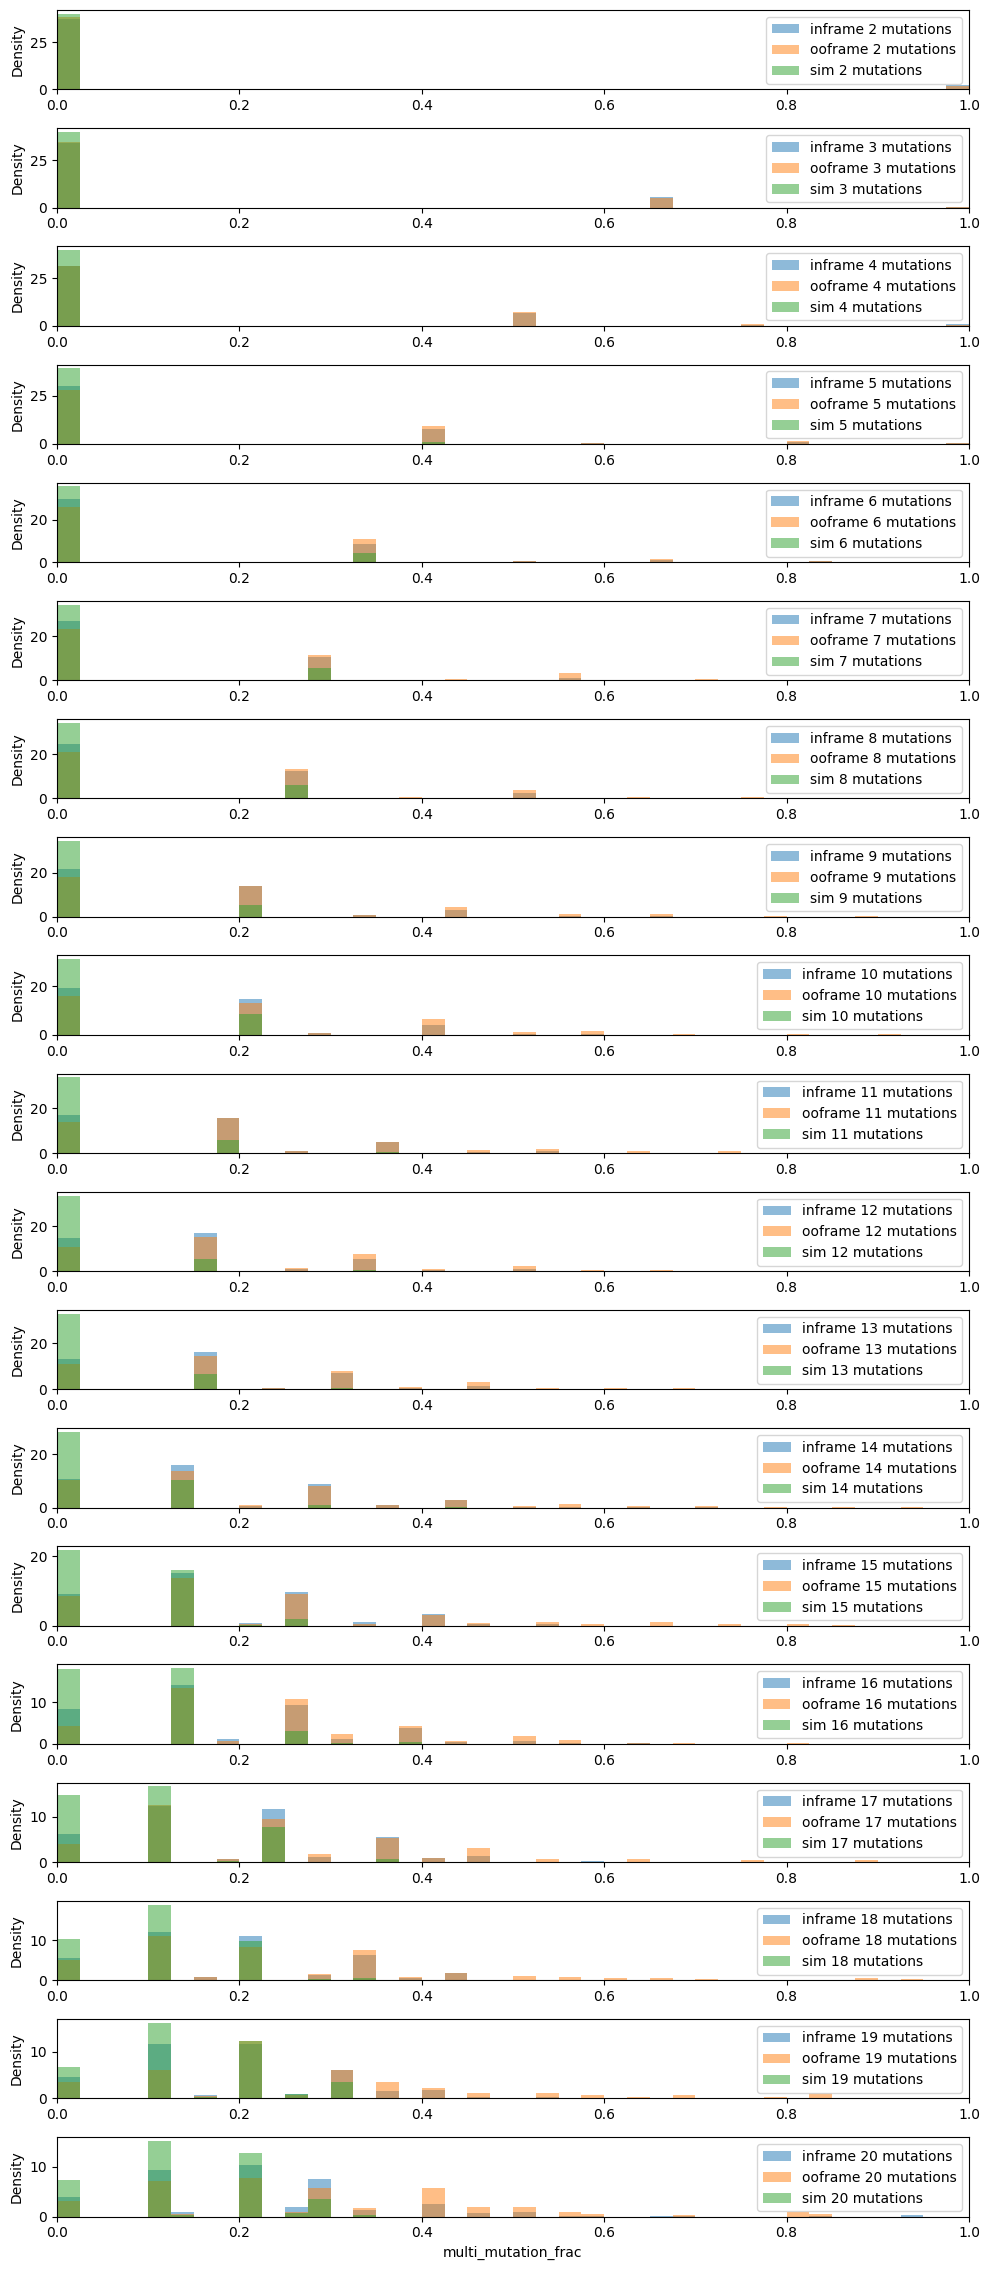

In [6]:
unique_counts = np.arange(2, 21)

# Create a single figure to hold all subplots
fig, axes = plt.subplots(len(unique_counts), 1, figsize=(10, 1.2 * len(unique_counts)))

# Loop through each unique count and plot
for i, count in enumerate(unique_counts):
    ax = axes[i]
    
    inframe_sub = inframe_df[inframe_df['nt_mutation_count'] == count]['multi_mutation_frac']
    ooframe_sub = ooframe_df[ooframe_df['nt_mutation_count'] == count]['multi_mutation_frac']
    sim_sub = sim_df[sim_df['nt_mutation_count'] == count]['multi_mutation_frac']
    
    if len(inframe_sub) == 0 and len(ooframe_sub) == 0:
        continue  # Skip this iteration if both filtered sets are empty
    
    ax.hist(inframe_sub, density=True, alpha=0.5, label=f'inframe {count} mutations', bins=40, range=(0, 1))
    ax.hist(ooframe_sub, density=True, alpha=0.5, label=f'ooframe {count} mutations', bins=40, range=(0, 1))
    ax.hist(sim_sub, density=True, alpha=0.5, label=f'sim {count} mutations', bins=40, range=(0, 1))
    
    ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
    ax.set_ylabel('Density')
    ax.legend()

plt.xlabel('multi_mutation_frac')
plt.tight_layout()
plt.show()


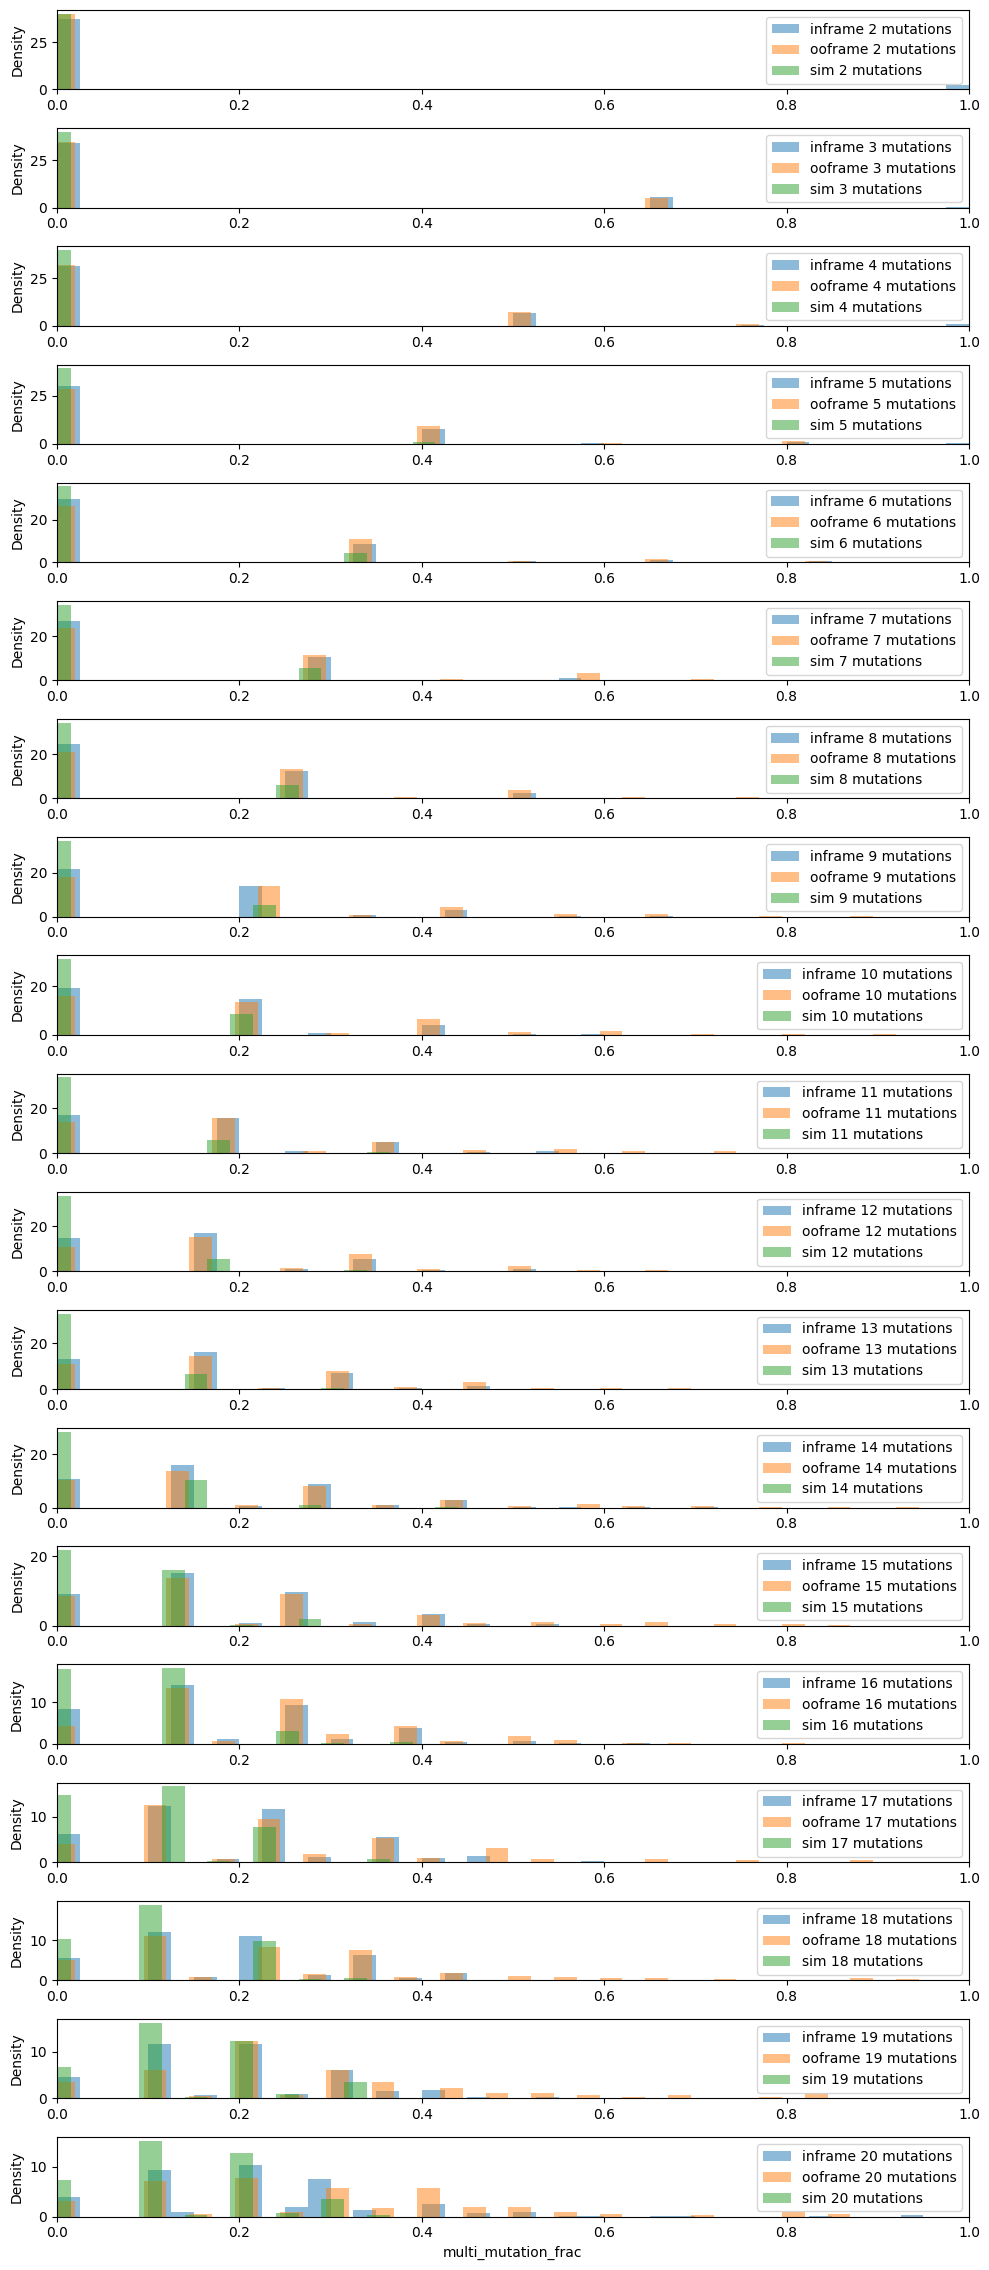

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure to hold all subplots
fig, axes = plt.subplots(len(unique_counts), 1, figsize=(10, 1.2 * len(unique_counts)))

# Loop through each unique count and plot
for i, count in enumerate(unique_counts):
    ax = axes[i]
    
    inframe_sub = inframe_df[inframe_df['nt_mutation_count'] == count]['multi_mutation_frac']
    ooframe_sub = ooframe_df[ooframe_df['nt_mutation_count'] == count]['multi_mutation_frac']
    sim_sub = sim_df[sim_df['nt_mutation_count'] == count]['multi_mutation_frac']
    
    if len(inframe_sub) == 0 and len(ooframe_sub) == 0:
        continue  # Skip this iteration if both filtered sets are empty

    # Shift the bins slightly for each dataset
    bins_inframe = np.linspace(0, 1, 41)
    bins_ooframe = np.linspace(0, 1, 41) - 0.005
    bins_sim = np.linspace(0, 1, 41) - 0.010
    
    ax.hist(inframe_sub, density=True, alpha=0.5, label=f'inframe {count} mutations', bins=bins_inframe)
    ax.hist(ooframe_sub, density=True, alpha=0.5, label=f'ooframe {count} mutations', bins=bins_ooframe)
    ax.hist(sim_sub, density=True, alpha=0.5, label=f'sim {count} mutations', bins=bins_sim)
    
    ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
    ax.set_ylabel('Density')
    ax.legend()

plt.xlabel('multi_mutation_frac')
plt.tight_layout()
plt.show()


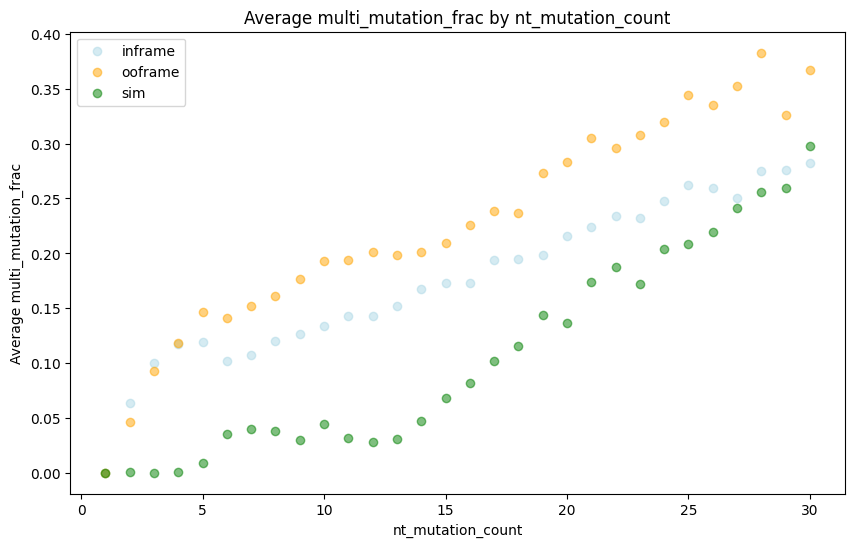

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute average multi_mutation_frac
def compute_avg_multi_mutation_frac(df):
    return df.groupby('nt_mutation_count')['multi_mutation_frac'].agg('mean').reset_index()

# Generate average multi_mutation_frac for all datasets
inframe_avg = compute_avg_multi_mutation_frac(inframe_df)
ooframe_avg = compute_avg_multi_mutation_frac(ooframe_df)
sim_avg = compute_avg_multi_mutation_frac(sim_df)

# Merge the datasets
merged_avg = pd.merge(inframe_avg, ooframe_avg, on='nt_mutation_count', suffixes=('_inframe', '_ooframe'))
merged_avg = pd.merge(merged_avg, sim_avg, on='nt_mutation_count', suffixes=('', '_sim'))
merged_avg = merged_avg[merged_avg['nt_mutation_count'] <= 30]

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(merged_avg['nt_mutation_count'], merged_avg['multi_mutation_frac_inframe'], 
            label='inframe', color='lightblue', alpha=0.5)

plt.scatter(merged_avg['nt_mutation_count'], merged_avg['multi_mutation_frac_ooframe'], 
            label='ooframe', color='orange', alpha=0.5)

plt.scatter(merged_avg['nt_mutation_count'], merged_avg['multi_mutation_frac'], 
            label='sim', color='green', alpha=0.5)

plt.xlabel('nt_mutation_count')
plt.ylabel('Average multi_mutation_frac')
plt.title('Average multi_mutation_frac by nt_mutation_count')
plt.legend()

plt.show()


In [9]:
a_multimut_row = inframe_df[inframe_df['multi_mutation_frac']==0.5].iloc[1]
print(a_multimut_row["parent"])
print(a_multimut_row["child"])
print("".join([str(int(x)) for x in a_multimut_row["nt_mutations"]]))

GAAGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGCCATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCTCAGGTATTAGTTGGAATAGTGGTAGCATAGGCTATGCGGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCTGAGGACACGGCCTTGTATTACTGTGCAAAAGACTCGTCCTACTACTACTACATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCCTCA
GAAGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGCAGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTTGATGATTATGCCATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCTCAGGTATTAGTTGGAATAGTGGTAGCATAGGCTATGCGGACTCTGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCCCTGTATCTGCAAATGAACAGTCTGAGAGCTGAGGACACGGCCTTGTATTACTGTGCAAAAGAGTTGTTATACTACTACTACATGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCCTCA
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

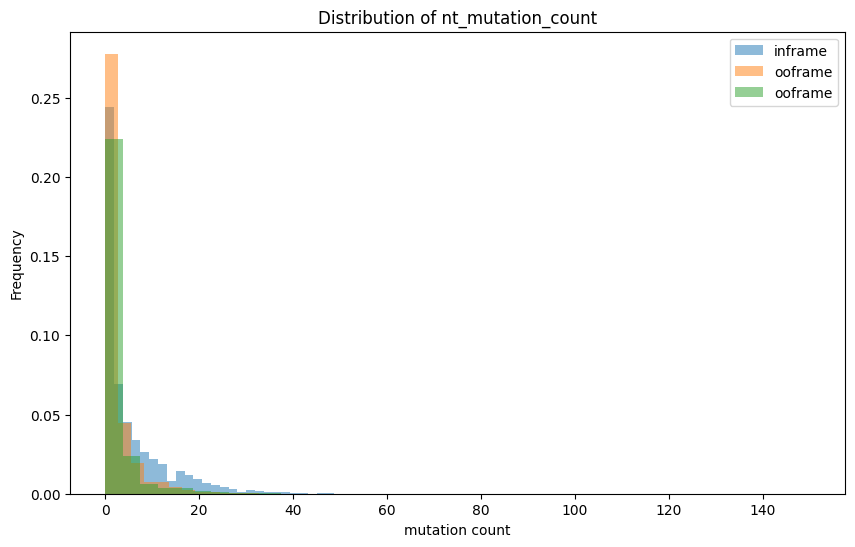

In [10]:
plt.figure(figsize=(10, 6))

plt.hist(inframe_df['nt_mutation_count'], density=True, alpha=0.5, label='inframe', bins=40)
plt.hist(ooframe_df['nt_mutation_count'], density=True, alpha=0.5, label='ooframe', bins=40)
plt.hist(sim_df['nt_mutation_count'], density=True, alpha=0.5, label='ooframe', bins=40)

plt.title('Distribution of nt_mutation_count')
plt.xlabel('mutation count')
plt.ylabel('Frequency')
plt.legend()

plt.show()